In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [12]:
train_df = pd.read_csv('train_combined_load_temp.csv', header=0)
test_df = pd.read_csv('test_combined_load_temp.csv', header=0)

In [13]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [14]:
train_df.head()

date  HourlyDryBulbTemperature        mw  hour_of_day  \
0 2017-02-01 00:53:00                      37.0  1419.881            0   
1 2017-02-01 01:53:00                      37.0  1379.505            1   
2 2017-02-01 02:53:00                      36.0  1366.106            2   
3 2017-02-01 03:53:00                      36.0  1364.453            3   
4 2017-02-01 04:53:00                      36.0  1391.265            4   

   day_of_week  month  year  
0            2      2  2017  
1            2      2  2017  
2            2      2  2017  
3            2      2  2017  
4            2      2  2017

### standardize the values/add square of temp
- [When Do You Need to Standardize the Variables in a Regression Model?](https://statisticsbyjim.com/regression/standardize-variables-regression/)
- [Normalize columns of pandas data frame](https://stackoverflow.com/a/41532180/16868474)

In [18]:
train_df['temp_std'] = (train_df['HourlyDryBulbTemperature'] - train_df['HourlyDryBulbTemperature'].mean())/train_df['HourlyDryBulbTemperature'].std()
train_df['load_std'] = (train_df['mw'] - train_df['mw'].mean())/train_df['mw'].std()
train_df['temp_sqr'] = train_df['temp_std'].apply(lambda x: x * x)
train_df.head()

### one hot encode hour_of_day, day_of_week and month

In [29]:
one_hot_train_df = train_df.join(pd.get_dummies(train_df['hour_of_day'], prefix='hod'))
one_hot_train_df = one_hot_train_df.join(pd.get_dummies(train_df['day_of_week'], prefix='dow'))
one_hot_train_df = one_hot_train_df.join(pd.get_dummies(train_df['month'], prefix='mo'))
one_hot_train_df.head()

date  HourlyDryBulbTemperature        mw  hour_of_day  \
0 2017-02-01 00:53:00                      37.0  1419.881            0   
1 2017-02-01 01:53:00                      37.0  1379.505            1   
2 2017-02-01 02:53:00                      36.0  1366.106            2   
3 2017-02-01 03:53:00                      36.0  1364.453            3   
4 2017-02-01 04:53:00                      36.0  1391.265            4   

   day_of_week  month  year  temp_std  load_std  temp_sqr  ...  mo_3  mo_4  \
0            2      2  2017 -0.871499 -0.489452  0.759511  ...     0     0   
1            2      2  2017 -0.871499 -0.630287  0.759511  ...     0     0   
2            2      2  2017 -0.924494 -0.677024  0.854690  ...     0     0   
3            2      2  2017 -0.924494 -0.682790  0.854690  ...     0     0   
4            2      2  2017 -0.924494 -0.589267  0.854690  ...     0     0   

   mo_5  mo_6  mo_7  mo_8  mo_9  mo_10  mo_11  mo_12  
0     0     0     0     0     0      0      0      0  
1     0     0     0     0     0      0      0      0  
2     0     0     0     0     0      0      0      0  
3     0     0     0     0     0      0      0      0  
4     0     0     0     0     0      0      0      0  

[5 rows x 53 columns]

### Select the features required for the OLS model by column prefix
There are too many columns to choose by name

In [52]:
# one_hot_train_df.dtypes

col_prefixes = ['temp_', 'hod_', 'dow_', 'mo_']

def is_one_of_col_prefixes(col_name, col_prefixes):
    starts_with_prefix = False
    for col_prefix in col_prefixes:
        if col_name.startswith(col_prefix):
            starts_with_prefix = True
            break
            
    return starts_with_prefix    

x_col_names = [index for index, value in one_hot_train_df.dtypes.items() if is_one_of_col_prefixes(index, col_prefixes)]
x_col_names

['temp_std',
 'temp_sqr',
 'hod_0',
 'hod_1',
 'hod_2',
 'hod_3',
 'hod_4',
 'hod_5',
 'hod_6',
 'hod_7',
 'hod_8',
 'hod_9',
 'hod_10',
 'hod_11',
 'hod_12',
 'hod_13',
 'hod_14',
 'hod_15',
 'hod_16',
 'hod_17',
 'hod_18',
 'hod_19',
 'hod_20',
 'hod_21',
 'hod_22',
 'hod_23',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'mo_1',
 'mo_2',
 'mo_3',
 'mo_4',
 'mo_5',
 'mo_6',
 'mo_7',
 'mo_8',
 'mo_9',
 'mo_10',
 'mo_11',
 'mo_12']

### OLS model

In [20]:
import statsmodels.api as sm

train_X = train_df['temp_std']
train_Y = train_df['load_std']

model = sm.OLS(train_Y, train_X).fit()
# predictions = model.predict(train_X)

print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:               load_std   R-squared (uncentered):                   0.107
Model:                            OLS   Adj. R-squared (uncentered):              0.107
Method:                 Least Squares   F-statistic:                              3069.
Date:                Mon, 21 Feb 2022   Prob (F-statistic):                        0.00
Time:                        08:55:49   Log-Likelihood:                         -34785.
No. Observations:               25536   AIC:                                  6.957e+04
Df Residuals:                   25535   BIC:                                  6.958e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [33]:
train_XM = one_hot_train_df[x_col_names]
modelm = sm.OLS(train_Y, train_XM).fit()

print_model = modelm.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               load_std   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     3180.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:46:36   Log-Likelihood:                -12858.
No. Observations:               25536   AIC:                         2.580e+04
Df Residuals:                   25493   BIC:                         2.615e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp_std       0.4499      0.005     86.748      0.0

### Adjusted R-squared (0-1 range, higher is better)
Linear Model with hour of day, day of week, month of year, temperature, and temperature squared: `0.839`

Compared to the model with just temperature this seems really good.

### Scatter plot of energy/temperature for months of January/July

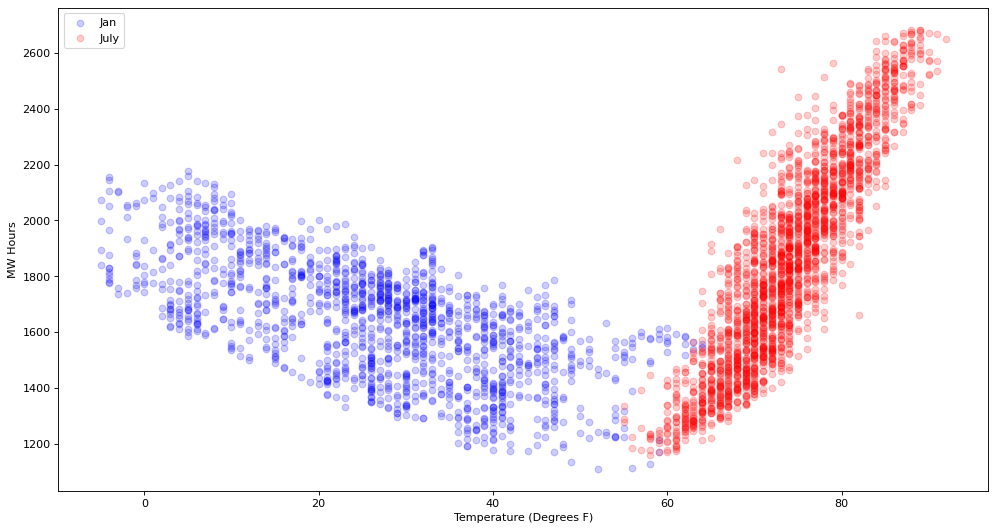

In [43]:
jan_train_df = train_df[train_df['month'] == 1]
jul_train_df = train_df[train_df['month'] == 7]

fig = plt.figure(figsize=(15, 8), dpi=80)
ax1 = fig.add_subplot(111)

ax1.scatter(jan_train_df['HourlyDryBulbTemperature'], jan_train_df['mw'], alpha = 0.2, c='b', label='Jan')
ax1.scatter(jul_train_df['HourlyDryBulbTemperature'], jul_train_df['mw'], alpha = 0.2, c='r', label='July')

plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')
plt.legend(loc='upper left');
fig.show()

### Scatterplot between energy and temperature, but only for the hours of midnight and noon

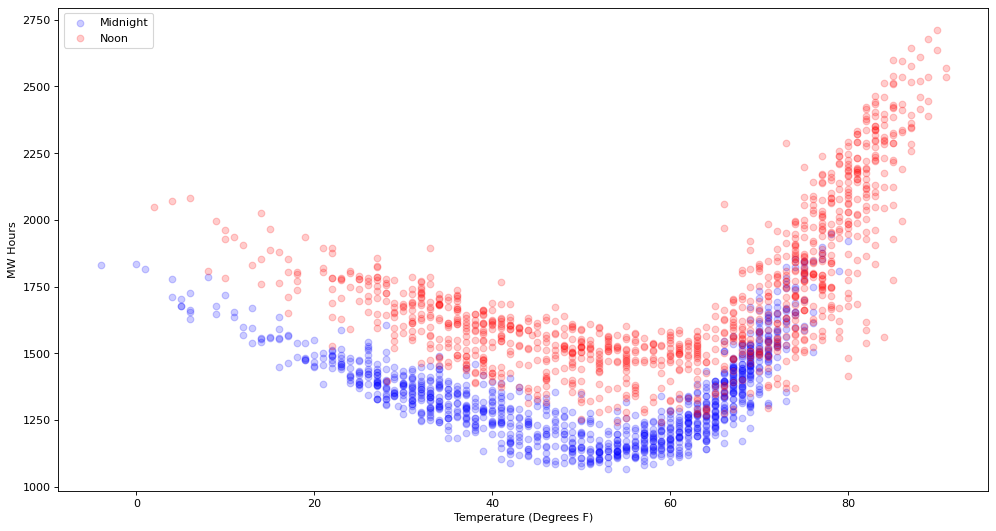

In [45]:
midnight_train_df = train_df[train_df['hour_of_day'] == 0]
noon_train_df = train_df[train_df['hour_of_day'] == 12]

fig = plt.figure(figsize=(15, 8), dpi=80)
ax1 = fig.add_subplot(111)

ax1.scatter(midnight_train_df['HourlyDryBulbTemperature'], midnight_train_df['mw'], alpha = 0.2, c='b', label='Midnight')
ax1.scatter(noon_train_df['HourlyDryBulbTemperature'], noon_train_df['mw'], alpha = 0.2, c='r', label='Noon')

plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')
plt.legend(loc='upper left');
fig.show()

### Add the `interaction` between hour of day, month of year and temperature

Remember that an `interaction` is just the *multiplication of two variables*. 
Luckily, using the formula approach of the `OLS.from_formula`function, we can easily add this into our models. 


If you wanted to build a linear regression with temperature, day of week, and the interaction between them 
(telling the model that the effect of temperature changes depending on the day of week), you could do the following:

```python    
    sm.OLS.from_formula('MW ~ Temp + C(day) + Temp*C(day)', data=train).fit().
```

In [57]:
temp_interaction_col_prefixes = ['hod_', 'mo_']

def add_temp_interaction_col(col_name):
    new_col_name, new_col_name_sqr = None, None
    
    for col_prefix in temp_interaction_col_prefixes:
        if col_name.startswith(col_prefix):
            new_col_name, new_col_name_sqr = f'inter_temp_std_{col_name}', f'inter_temp_sqr_{col_name}'
            one_hot_train_df[new_col_name] =  one_hot_train_df['temp_std'] * one_hot_train_df[col_name]
            one_hot_train_df[new_col_name_sqr] =  one_hot_train_df['temp_sqr'] * one_hot_train_df[col_name]
            break
            
    return new_col_name, new_col_name_sqr

In [59]:
interaction_cols = [add_temp_interaction_col(index) for index, value in one_hot_train_df.dtypes.items() if is_one_of_col_prefixes(index, temp_interaction_col_prefixes)]
interaction_cols

[('inter_temp_std_hod_0', 'inter_temp_sqr_hod_0'),
 ('inter_temp_std_hod_1', 'inter_temp_sqr_hod_1'),
 ('inter_temp_std_hod_2', 'inter_temp_sqr_hod_2'),
 ('inter_temp_std_hod_3', 'inter_temp_sqr_hod_3'),
 ('inter_temp_std_hod_4', 'inter_temp_sqr_hod_4'),
 ('inter_temp_std_hod_5', 'inter_temp_sqr_hod_5'),
 ('inter_temp_std_hod_6', 'inter_temp_sqr_hod_6'),
 ('inter_temp_std_hod_7', 'inter_temp_sqr_hod_7'),
 ('inter_temp_std_hod_8', 'inter_temp_sqr_hod_8'),
 ('inter_temp_std_hod_9', 'inter_temp_sqr_hod_9'),
 ('inter_temp_std_hod_10', 'inter_temp_sqr_hod_10'),
 ('inter_temp_std_hod_11', 'inter_temp_sqr_hod_11'),
 ('inter_temp_std_hod_12', 'inter_temp_sqr_hod_12'),
 ('inter_temp_std_hod_13', 'inter_temp_sqr_hod_13'),
 ('inter_temp_std_hod_14', 'inter_temp_sqr_hod_14'),
 ('inter_temp_std_hod_15', 'inter_temp_sqr_hod_15'),
 ('inter_temp_std_hod_16', 'inter_temp_sqr_hod_16'),
 ('inter_temp_std_hod_17', 'inter_temp_sqr_hod_17'),
 ('inter_temp_std_hod_18', 'inter_temp_sqr_hod_18'),
 ('inter_temp

In [60]:
one_hot_train_df.head()

date  HourlyDryBulbTemperature        mw  hour_of_day  \
0 2017-02-01 00:53:00                      37.0  1419.881            0   
1 2017-02-01 01:53:00                      37.0  1379.505            1   
2 2017-02-01 02:53:00                      36.0  1366.106            2   
3 2017-02-01 03:53:00                      36.0  1364.453            3   
4 2017-02-01 04:53:00                      36.0  1391.265            4   

   day_of_week  month  year  temp_std  load_std  temp_sqr  ...  \
0            2      2  2017 -0.871499 -0.489452  0.759511  ...   
1            2      2  2017 -0.871499 -0.630287  0.759511  ...   
2            2      2  2017 -0.924494 -0.677024  0.854690  ...   
3            2      2  2017 -0.924494 -0.682790  0.854690  ...   
4            2      2  2017 -0.924494 -0.589267  0.854690  ...   

   inter_temp_sqr_mo_3  inter_temp_sqr_mo_4  inter_temp_sqr_mo_5  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   inter_temp_sqr_mo_6  inter_temp_sqr_mo_7  inter_temp_sqr_mo_8  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   inter_temp_sqr_mo_9  inter_temp_sqr_mo_10  inter_temp_sqr_mo_11  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   

   inter_temp_sqr_mo_12  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 125 columns]

In [61]:
one_hot_train_df.dtypes

date                        datetime64[ns]
HourlyDryBulbTemperature           float64
mw                                 float64
hour_of_day                          int64
day_of_week                          int64
                                 ...      
inter_temp_sqr_mo_8                float64
inter_temp_sqr_mo_9                float64
inter_temp_sqr_mo_10               float64
inter_temp_sqr_mo_11               float64
inter_temp_sqr_mo_12               float64
Length: 125, dtype: object

In [63]:
inter_col_prefixes = ['temp_', 'hod_', 'dow_', 'mo_', 'inter_temp_std_', 'inter_temp_sqr_']

inter_col_names = [index for index, value in one_hot_train_df.dtypes.items() if is_one_of_col_prefixes(index, inter_col_prefixes)]
inter_col_names

['temp_std',
 'temp_sqr',
 'hod_0',
 'hod_1',
 'hod_2',
 'hod_3',
 'hod_4',
 'hod_5',
 'hod_6',
 'hod_7',
 'hod_8',
 'hod_9',
 'hod_10',
 'hod_11',
 'hod_12',
 'hod_13',
 'hod_14',
 'hod_15',
 'hod_16',
 'hod_17',
 'hod_18',
 'hod_19',
 'hod_20',
 'hod_21',
 'hod_22',
 'hod_23',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'mo_1',
 'mo_2',
 'mo_3',
 'mo_4',
 'mo_5',
 'mo_6',
 'mo_7',
 'mo_8',
 'mo_9',
 'mo_10',
 'mo_11',
 'mo_12',
 'inter_temp_std_hod_0',
 'inter_temp_std_hod_1',
 'inter_temp_std_hod_2',
 'inter_temp_std_hod_3',
 'inter_temp_std_hod_4',
 'inter_temp_std_hod_5',
 'inter_temp_std_hod_6',
 'inter_temp_std_hod_7',
 'inter_temp_std_hod_8',
 'inter_temp_std_hod_9',
 'inter_temp_std_hod_10',
 'inter_temp_std_hod_11',
 'inter_temp_std_hod_12',
 'inter_temp_std_hod_13',
 'inter_temp_std_hod_14',
 'inter_temp_std_hod_15',
 'inter_temp_std_hod_16',
 'inter_temp_std_hod_17',
 'inter_temp_std_hod_18',
 'inter_temp_std_hod_19',
 'inter_temp_std_hod_20',
 'i

In [64]:
train_XN = one_hot_train_df[inter_col_names]
model_inter = sm.OLS(train_Y, train_XN).fit()

print_model = model_inter.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               load_std   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2416.
Date:                Sun, 27 Feb 2022   Prob (F-statistic):               0.00
Time:                        04:42:47   Log-Likelihood:                -5100.4
No. Observations:               25536   AIC:                         1.042e+04
Df Residuals:                   25425   BIC:                         1.133e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
temp_std                  0.02

### New adjusted $ R^2 $: 0.912

### Add columns for interaction between hour of day and day of week colums

In [69]:
def get_col_names_with_prefix(df, prefix):
    return [index for index, value in df.dtypes.items() if index.startswith(prefix) ]

def add_interaction_col(df, left_col_name, right_col_name):
    new_col_name = f'{left_col_name}_{right_col_name}'
    df[new_col_name] = df[left_col_name] * df[right_col_name]
    return new_col_name

hod_cols = get_col_names_with_prefix(one_hot_train_df, 'hod_')
dow_cols = get_col_names_with_prefix(one_hot_train_df, 'dow_')
hod_cols, dow_cols

(['hod_0',
  'hod_1',
  'hod_2',
  'hod_3',
  'hod_4',
  'hod_5',
  'hod_6',
  'hod_7',
  'hod_8',
  'hod_9',
  'hod_10',
  'hod_11',
  'hod_12',
  'hod_13',
  'hod_14',
  'hod_15',
  'hod_16',
  'hod_17',
  'hod_18',
  'hod_19',
  'hod_20',
  'hod_21',
  'hod_22',
  'hod_23'],
 ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6'])

In [70]:
for hod_col in hod_cols:
    for dow_col in dow_cols:
        new_col = add_interaction_col(one_hot_train_df, hod_col, dow_col)
        print(new_col)


hod_0_dow_0
hod_0_dow_1
hod_0_dow_2
hod_0_dow_3
hod_0_dow_4
hod_0_dow_5
hod_0_dow_6
hod_1_dow_0
hod_1_dow_1
hod_1_dow_2
hod_1_dow_3
hod_1_dow_4
hod_1_dow_5
hod_1_dow_6
hod_2_dow_0
hod_2_dow_1
hod_2_dow_2
hod_2_dow_3
hod_2_dow_4
hod_2_dow_5
hod_2_dow_6
hod_3_dow_0
hod_3_dow_1
hod_3_dow_2
hod_3_dow_3
hod_3_dow_4
hod_3_dow_5
hod_3_dow_6
hod_4_dow_0
hod_4_dow_1
hod_4_dow_2
hod_4_dow_3
hod_4_dow_4
hod_4_dow_5
hod_4_dow_6
hod_5_dow_0
hod_5_dow_1
hod_5_dow_2
hod_5_dow_3
hod_5_dow_4
hod_5_dow_5
hod_5_dow_6
hod_6_dow_0
hod_6_dow_1
hod_6_dow_2
hod_6_dow_3
hod_6_dow_4
hod_6_dow_5
hod_6_dow_6
hod_7_dow_0
hod_7_dow_1
hod_7_dow_2
hod_7_dow_3
hod_7_dow_4
hod_7_dow_5
hod_7_dow_6
hod_8_dow_0
hod_8_dow_1
hod_8_dow_2
hod_8_dow_3
hod_8_dow_4
hod_8_dow_5
hod_8_dow_6
hod_9_dow_0
hod_9_dow_1
hod_9_dow_2
hod_9_dow_3
hod_9_dow_4
hod_9_dow_5
hod_9_dow_6
hod_10_dow_0
hod_10_dow_1
hod_10_dow_2
hod_10_dow_3
hod_10_dow_4
hod_10_dow_5
hod_10_dow_6
hod_11_dow_0
hod_11_dow_1
hod_11_dow_2
hod_11_dow_3
hod_11_dow_4
hod_

/tmp/ipykernel_218/3043497553.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df[left_col_name] * df[right_col_name]


In [72]:
inter_col_names = [index for index, value in one_hot_train_df.dtypes.items() if is_one_of_col_prefixes(index, inter_col_prefixes)]
len(inter_col_names)

285

In [73]:
train_XN2 = one_hot_train_df[inter_col_names]
model_inter2 = sm.OLS(train_Y, train_XN2).fit()

print_model = model_inter2.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               load_std   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1248.
Date:                Sun, 27 Feb 2022   Prob (F-statistic):               0.00
Time:                        05:24:12   Log-Likelihood:                -3247.2
No. Observations:               25536   AIC:                             6992.
Df Residuals:                   25287   BIC:                             9021.
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
temp_std                  0.02

### New Adj. R-squared: 0.924

### Predictions from final linear regression model & MAPE


In [75]:
predictions = model_inter2.predict(train_XN2)

In [92]:
train_XN2.head()

temp_std  temp_sqr  hod_0  hod_1  hod_2  hod_3  hod_4  hod_5  hod_6  hod_7  \
0 -0.871499  0.759511      1      0      0      0      0      0      0      0   
1 -0.871499  0.759511      0      1      0      0      0      0      0      0   
2 -0.924494  0.854690      0      0      1      0      0      0      0      0   
3 -0.924494  0.854690      0      0      0      1      0      0      0      0   
4 -0.924494  0.854690      0      0      0      0      1      0      0      0   

   ...  hod_22_dow_4  hod_22_dow_5  hod_22_dow_6  hod_23_dow_0  hod_23_dow_1  \
0  ...             0             0             0             0             0   
1  ...             0             0             0             0             0   
2  ...             0             0             0             0             0   
3  ...             0             0             0             0             0   
4  ...             0             0             0             0             0   

   hod_23_dow_2  hod_23_dow_3  hod_23_dow_4  hod_23_dow_5  hod_23_dow_6  
0             0             0             0             0             0  
1             0             0             0             0             0  
2             0             0             0             0             0  
3             0             0             0             0             0  
4             0             0             0             0             0  

[5 rows x 285 columns]

In [77]:
predictions.head()

0   -0.767131
1   -0.868455
2   -0.861896
3   -0.830740
4   -0.667936
dtype: float64

In [78]:
### reverse this `train_df['load_std'] = (train_df['mw'] - train_df['mw'].mean())/train_df['mw'].std()`
load_mean = train_df['mw'].mean()
load_std_dev = train_df['mw'].std()
load_mean, load_std_dev

(1560.2021741854637, 286.6902647599262)

In [79]:
pred_Y = (predictions * load_std_dev) + load_mean

In [95]:
pred_Y.head(), one_hot_train_df['mw'].head()

(0    1340.273043
 1    1311.224494
 2    1313.105097
 3    1322.037175
 4    1368.711449
 dtype: float64,
 0    1419.881
 1    1379.505
 2    1366.106
 3    1364.453
 4    1391.265
 Name: mw, dtype: float64)

In [97]:
error_percent = (one_hot_train_df['mw'] - pred_Y) / one_hot_train_df['mw']
error_percent.head()

0    0.056067
1    0.049496
2    0.038797
3    0.031086
4    0.016211
dtype: float64

In [98]:
error_percent.apply(lambda x: abs(x) * 100).head(20)

0     5.606664
1     4.949638
2     3.879706
3     3.108632
4     1.621082
5     1.051376
6     0.664538
7     1.635781
8     2.294370
9     1.911770
10    1.334415
11    2.052729
12    1.780701
13    2.598134
14    2.384119
15    1.919335
16    2.425019
17    3.696994
18    4.212364
19    2.480358
dtype: float64

In [102]:
mape_fraction = error_percent.apply(lambda x: abs(x)).sum() / error_percent.count()
mape = mape_fraction * 100
print(f"MAPE of last model: {mape}")

MAPE of last model: 3.511954103205508


### predictions on test data set

In [105]:
# standardize temp and add temperature squared column
test_df['temp_std'] = (test_df['HourlyDryBulbTemperature'] - train_df['HourlyDryBulbTemperature'].mean())/train_df['HourlyDryBulbTemperature'].std()
test_df['temp_sqr'] = test_df['temp_std'].apply(lambda x: x * x)

# one hot encode date
one_hot_test_df = test_df.join(pd.get_dummies(test_df['hour_of_day'], prefix='hod'))
one_hot_test_df = one_hot_test_df.join(pd.get_dummies(one_hot_test_df['day_of_week'], prefix='dow'))
one_hot_test_df = one_hot_test_df.join(pd.get_dummies(one_hot_test_df['month'], prefix='mo'))

one_hot_test_df.head()

date  HourlyDryBulbTemperature        mw  hour_of_day  \
0 2020-01-01 00:53:00                      31.0  1363.428            0   
1 2020-01-01 01:53:00                      29.0  1335.975            1   
2 2020-01-01 02:53:00                      30.0  1296.817            2   
3 2020-01-01 03:53:00                      30.0  1288.403            3   
4 2020-01-01 04:53:00                      31.0  1292.263            4   

   day_of_week  month  year  temp_std  temp_sqr  hod_0  ...  hod_22  hod_23  \
0            2      1  2020 -1.189471  1.414842      1  ...       0       0   
1            2      1  2020 -1.295462  1.678223      0  ...       0       0   
2            2      1  2020 -1.242467  1.543724      0  ...       0       0   
3            2      1  2020 -1.242467  1.543724      0  ...       0       0   
4            2      1  2020 -1.189471  1.414842      0  ...       0       0   

   dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  mo_1  
0      0      0      1      0      0      0      0     1  
1      0      0      1      0      0      0      0     1  
2      0      0      1      0      0      0      0     1  
3      0      0      1      0      0      0      0     1  
4      0      0      1      0      0      0      0     1  

[5 rows x 41 columns]

In [106]:
# add interaction between temp and 
interaction_cols = [add_temp_interaction_col(index) for index, value in one_hot_test_df.dtypes.items() if is_one_of_col_prefixes(index, temp_interaction_col_prefixes)]
interaction_cols

[('inter_temp_std_hod_0', 'inter_temp_sqr_hod_0'),
 ('inter_temp_std_hod_1', 'inter_temp_sqr_hod_1'),
 ('inter_temp_std_hod_2', 'inter_temp_sqr_hod_2'),
 ('inter_temp_std_hod_3', 'inter_temp_sqr_hod_3'),
 ('inter_temp_std_hod_4', 'inter_temp_sqr_hod_4'),
 ('inter_temp_std_hod_5', 'inter_temp_sqr_hod_5'),
 ('inter_temp_std_hod_6', 'inter_temp_sqr_hod_6'),
 ('inter_temp_std_hod_7', 'inter_temp_sqr_hod_7'),
 ('inter_temp_std_hod_8', 'inter_temp_sqr_hod_8'),
 ('inter_temp_std_hod_9', 'inter_temp_sqr_hod_9'),
 ('inter_temp_std_hod_10', 'inter_temp_sqr_hod_10'),
 ('inter_temp_std_hod_11', 'inter_temp_sqr_hod_11'),
 ('inter_temp_std_hod_12', 'inter_temp_sqr_hod_12'),
 ('inter_temp_std_hod_13', 'inter_temp_sqr_hod_13'),
 ('inter_temp_std_hod_14', 'inter_temp_sqr_hod_14'),
 ('inter_temp_std_hod_15', 'inter_temp_sqr_hod_15'),
 ('inter_temp_std_hod_16', 'inter_temp_sqr_hod_16'),
 ('inter_temp_std_hod_17', 'inter_temp_sqr_hod_17'),
 ('inter_temp_std_hod_18', 'inter_temp_sqr_hod_18'),
 ('inter_temp

In [107]:
for hod_col in hod_cols:
    for dow_col in dow_cols:
        new_col = add_interaction_col(one_hot_test_df, hod_col, dow_col)
        print(new_col)



hod_0_dow_0
hod_0_dow_1
hod_0_dow_2
hod_0_dow_3
hod_0_dow_4
hod_0_dow_5
hod_0_dow_6
hod_1_dow_0
hod_1_dow_1
hod_1_dow_2
hod_1_dow_3
hod_1_dow_4
hod_1_dow_5
hod_1_dow_6
hod_2_dow_0
hod_2_dow_1
hod_2_dow_2
hod_2_dow_3
hod_2_dow_4
hod_2_dow_5
hod_2_dow_6
hod_3_dow_0
hod_3_dow_1
hod_3_dow_2
hod_3_dow_3
hod_3_dow_4
hod_3_dow_5
hod_3_dow_6
hod_4_dow_0
hod_4_dow_1
hod_4_dow_2
hod_4_dow_3
hod_4_dow_4
hod_4_dow_5
hod_4_dow_6
hod_5_dow_0
hod_5_dow_1
hod_5_dow_2
hod_5_dow_3
hod_5_dow_4
hod_5_dow_5
hod_5_dow_6
hod_6_dow_0
hod_6_dow_1
hod_6_dow_2
hod_6_dow_3
hod_6_dow_4
hod_6_dow_5
hod_6_dow_6
hod_7_dow_0
hod_7_dow_1
hod_7_dow_2
hod_7_dow_3
hod_7_dow_4
hod_7_dow_5
hod_7_dow_6
hod_8_dow_0
hod_8_dow_1
hod_8_dow_2
hod_8_dow_3
hod_8_dow_4
hod_8_dow_5
hod_8_dow_6
hod_9_dow_0
hod_9_dow_1
hod_9_dow_2
hod_9_dow_3
hod_9_dow_4
hod_9_dow_5
hod_9_dow_6
hod_10_dow_0
hod_10_dow_1
hod_10_dow_2
hod_10_dow_3
hod_10_dow_4
hod_10_dow_5
hod_10_dow_6
hod_11_dow_0
hod_11_dow_1
hod_11_dow_2
hod_11_dow_3
hod_11_dow_4
hod_

/tmp/ipykernel_218/3043497553.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df[left_col_name] * df[right_col_name]


In [114]:
inter_col_names_test = [index for index, value in one_hot_test_df.dtypes.items() if is_one_of_col_prefixes(index, inter_col_prefixes)]

# add zero columns for missing interactions columns (due to only 1 month of data)
cols_to_add = set(inter_col_names) - set(inter_col_names_test)

for col_to_add in cols_to_add:
    one_hot_test_df[col_to_add] = 0

test_X = one_hot_test_df[inter_col_names]
test_X.shape

In [117]:
test_predictions = model_inter2.predict(test_X)

In [118]:
test_predictions.head()

0   -0.334982
1   -0.300808
2   -0.378377
3   -0.323695
4   -0.188470
dtype: float64

In [119]:
predictions_test_scaled = (test_predictions * load_std_dev) + load_mean
predictions_test_scaled.head()

0    1464.166087
1    1473.963311
2    1451.725040
3    1467.401887
4    1506.169549
dtype: float64

### Plot of test data load vs predictions from last model

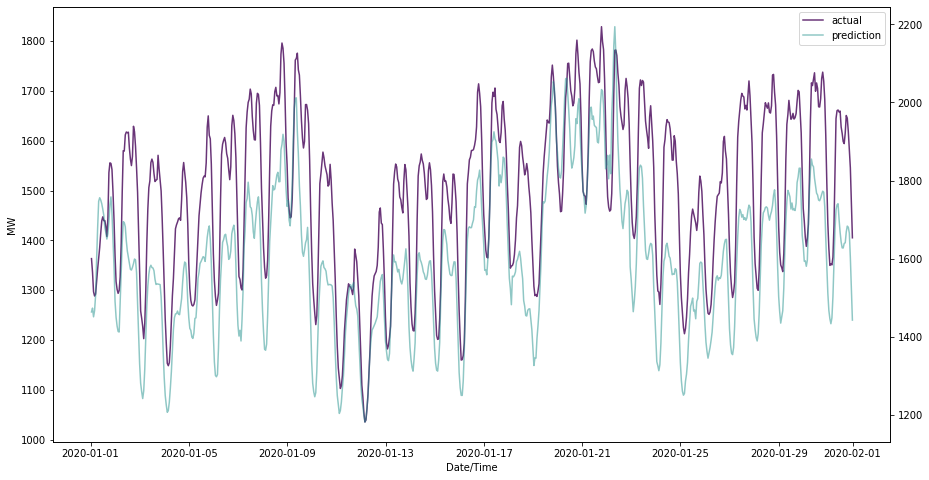

In [122]:
color1 = plt.cm.viridis(1)
color2 = plt.cm.viridis(0.5)

fig, host = plt.subplots(figsize=(15,8))
par = host.twinx()

host.set_xlabel("Date/Time")
host.set_ylabel("MW")

p1, = host.plot(one_hot_test_df['date'], one_hot_test_df['mw'], color=color1, label="actual", alpha=0.8)
p2, = par.plot(one_hot_test_df['date'], predictions_test_scaled, color=color2, label="prediction", alpha=0.5)

lns = [p1, p2]
host.legend(handles=lns, loc='best')